This notebook predicts on 4 categories: IDD & music, IDD & rest, TDC & music, TDC & rest

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import pywt
from scipy import signal
from tqdm import tqdm

%matplotlib inline

## Load data

In [2]:
data_path = "Data/GeneratedData/combined_data/"
base_path = os.getcwd()

# REST
IDD_rest = np.load(os.path.join(data_path, "IDD_rest.npy"))
TDC_rest = np.load(os.path.join(data_path, "TDC_rest.npy"))

# MUSIC
IDD_music = np.load(os.path.join(data_path, "IDD_music.npy"))
TDC_music = np.load(os.path.join(data_path, "TDC_music.npy"))

X = np.concatenate((IDD_rest, TDC_rest, IDD_music, IDD_rest))
Y = [0]*len(IDD_rest) + [1]*len(TDC_rest) + [2]*len(IDD_music) + [3]*len(TDC_music)
  
Y = np.asarray(Y)
Y = LabelBinarizer().fit_transform(Y)

In [3]:
# X = np.asarray(X)
# Y = np.asarray(Y)


In [4]:
print(X.shape)
print(Y.shape)

(16940, 14, 256)
(16940, 4)


## Create Spectrograms

In [21]:
# Modified scalogram function from Fusion notebook
def scalogram(x, Hz, hz, start_sec, num_secs, w = 5.):
    ''' x = time series
        Hz = sampling rate in Hz of the input signal
        hz = desired sampling rate (by downsampling)
        start_sec = starting second in x
        num_secs = total number of seconds of our clip
        w = width parameter
        log =raw_seiz if true take log of spectrum values
    '''

    downsample = int(round(Hz / hz))
    X = x[start_sec * Hz: (start_sec + num_secs) * Hz : downsample]

    t, dt = np.linspace(start_sec, start_sec + num_secs, hz * num_secs, retstep = True)
    fs = 1 / dt

    freq = np.linspace(1, fs / 2, int(hz / 2))
    widths = w * fs / (2 * np.pi * freq)

    cwtm = signal.cwt(X,
                      signal.morlet2,
                      widths,
                      w = w)
    return cwtm

In [25]:
def generate_scalogram(data):
    scalogram_data = []
    for sample in tqdm(data):
        scalograms = []
        for channel in sample:
            scalograms.append(scalogram(channel, 128, 64, 0, 2))
        scalogram_data.append(np.concatenate(scalograms))
    return np.asarray(scalogram_data)



In [26]:
def generate_scalogram_np(data):
    scalogram_data = np.zeros((data.shape[0], data.shape[1], 32, 128))
    for sample in tqdm(range(data.shape[0])):
        for channel in range(data.shape[1]):
            scalogram_data[sample, channel] = scalogram(data[sample][channel], 128, 64, 0, 2)
    return scalogram_data

In [31]:
X_scalogram = generate_scalogram(X)

100%|██████████| 16940/16940 [08:44<00:00, 32.30it/s]


In [32]:
X_scalogram.shape

(16940, 448, 128)

In [34]:
# reshape data
X_scalogram = X_scalogram.reshape(X_scalogram.shape[0], X_scalogram.shape[1], X_scalogram.shape[2], 1)
X_scalogram.shape

(16940, 448, 128, 1)

## Test-Train split

In [35]:
X_train, X_val, y_train, y_val = train_test_split(X_scalogram, Y, test_size=0.2, random_state=22)

In [64]:
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=22)

In [36]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
# print("X_test shape:", X_test.shape)
# print("y_test shape:", y_test.shape)
input_shape = X_train.shape[1:]

X_train shape: (13552, 448, 128, 1)
y_train shape: (13552, 4)
X_val shape: (3388, 448, 128, 1)
y_val shape: (3388, 4)


## Model

In [37]:
model = keras.Sequential([
    # Set input layer
    keras.layers.InputLayer(input_shape=input_shape),
    
    # Conv + Maxpooling
    keras.layers.Conv2D(8, (3, 3), padding="same", activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Normalization
    keras.layers.BatchNormalization(),
    
    # Flatten and convert from 3D to 1D
    keras.layers.Flatten(),
    
    # Sigmoid
    keras.layers.Dense(4, activation=tf.nn.softmax)
])


In [38]:
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 448, 128, 8)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 224, 64, 8)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 64, 8)        32        
_________________________________________________________________
flatten (Flatten)            (None, 114688)            0         
_________________________________________________________________
dense (Dense)                (None, 4)                 458756    
Total params: 458,868
Trainable params: 458,852
Non-trainable params: 16
_________________________________________________________________


In [40]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=10, 
                    batch_size=256,
                    validation_data=(X_val, y_val), 
                    verbose=1)

Train on 13552 samples, validate on 3388 samples
Epoch 1/10
13552/13552 [==============================] - 180s 13ms/sample - loss: 5.0124 - accuracy: 0.5230 - val_loss: 2.6419 - val_accuracy: 0.5431
Epoch 2/10
13552/13552 [==============================] - 174s 13ms/sample - loss: 1.9530 - accuracy: 0.6497 - val_loss: 1.8226 - val_accuracy: 0.5897
Epoch 3/10
13552/13552 [==============================] - 183s 14ms/sample - loss: 1.8128 - accuracy: 0.6761 - val_loss: 1.8856 - val_accuracy: 0.5688
Epoch 4/10
13552/13552 [==============================] - 175s 13ms/sample - loss: 1.8904 - accuracy: 0.6816 - val_loss: 2.1306 - val_accuracy: 0.6092
Epoch 5/10
13552/13552 [==============================] - 180s 13ms/sample - loss: 1.6866 - accuracy: 0.6980 - val_loss: 2.0539 - val_accuracy: 0.5779
Epoch 6/10
13552/13552 [==============================] - 184s 14ms/sample - loss: 1.8276 - accuracy: 0.7007 - val_loss: 1.7314 - val_accuracy: 0.5490
Epoch 7/10
13552/13552 [=====================

* Music
    * Validation accuracy: 99.47%
    * Validation loss: 0.0161
* Rest


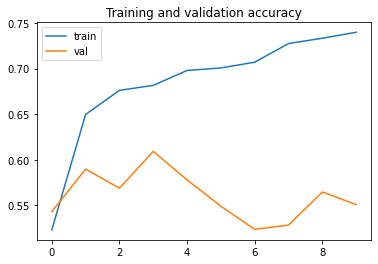

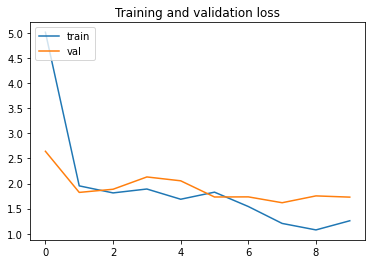

In [41]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.legend(['train', 'val'], loc='upper left')
# plt.legend(['train'], loc='upper left')


plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')
plt.legend(['train', 'val'], loc='upper left')
# plt.legend(['train'], loc='upper left')

In [ ]:
# test_loss, test_acc = model.evaluate(X_test, y_test)
#
# print('Test accuracy:', test_acc)
# print('Test loss:', test_loss)